# Import Libraries and Load Data

In [1]:
# pip install medmnist

In [2]:
import medmnist
from medmnist import INFO, BloodMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import cv2
from skimage import morphology, measure
from skimage.color import rgb2gray
import random

In [3]:
# Load the BloodMNIST dataset with high resolution for all splits
train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz


# See Class Distribution

In [4]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: /Users/lowi33/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    

In [5]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in train_data])

In [6]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


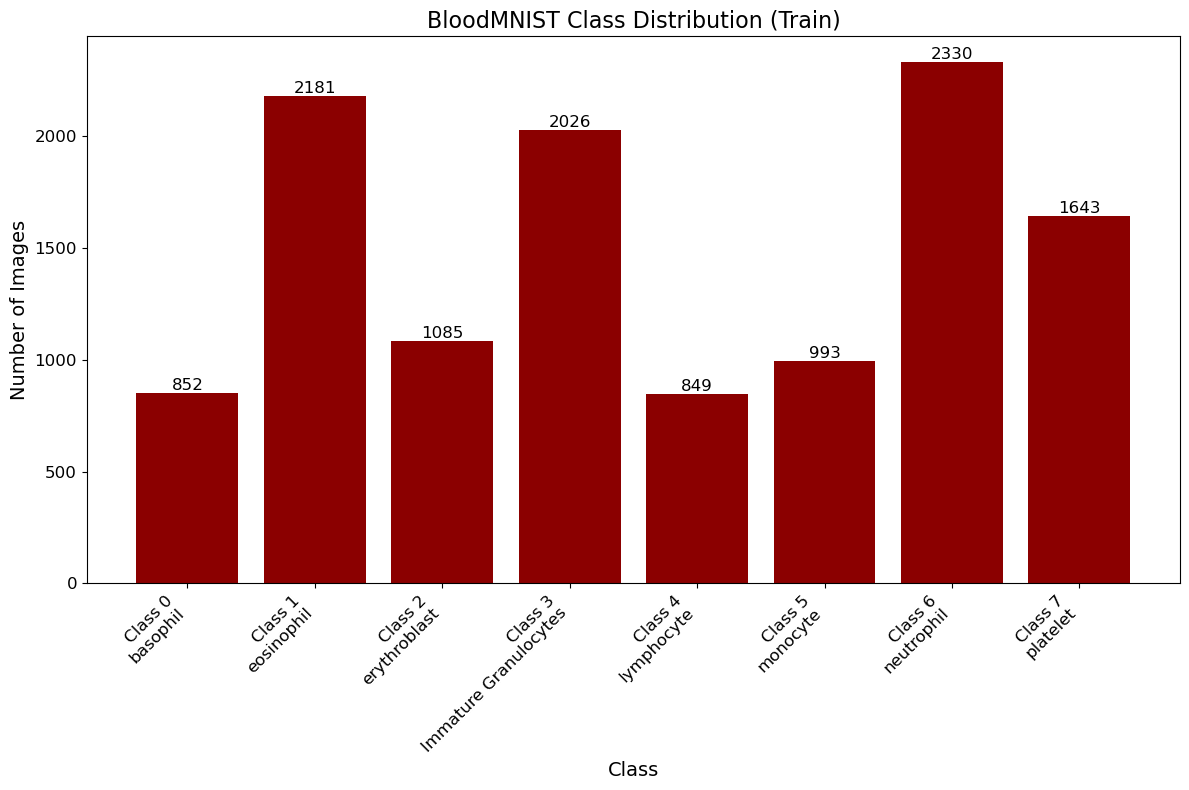

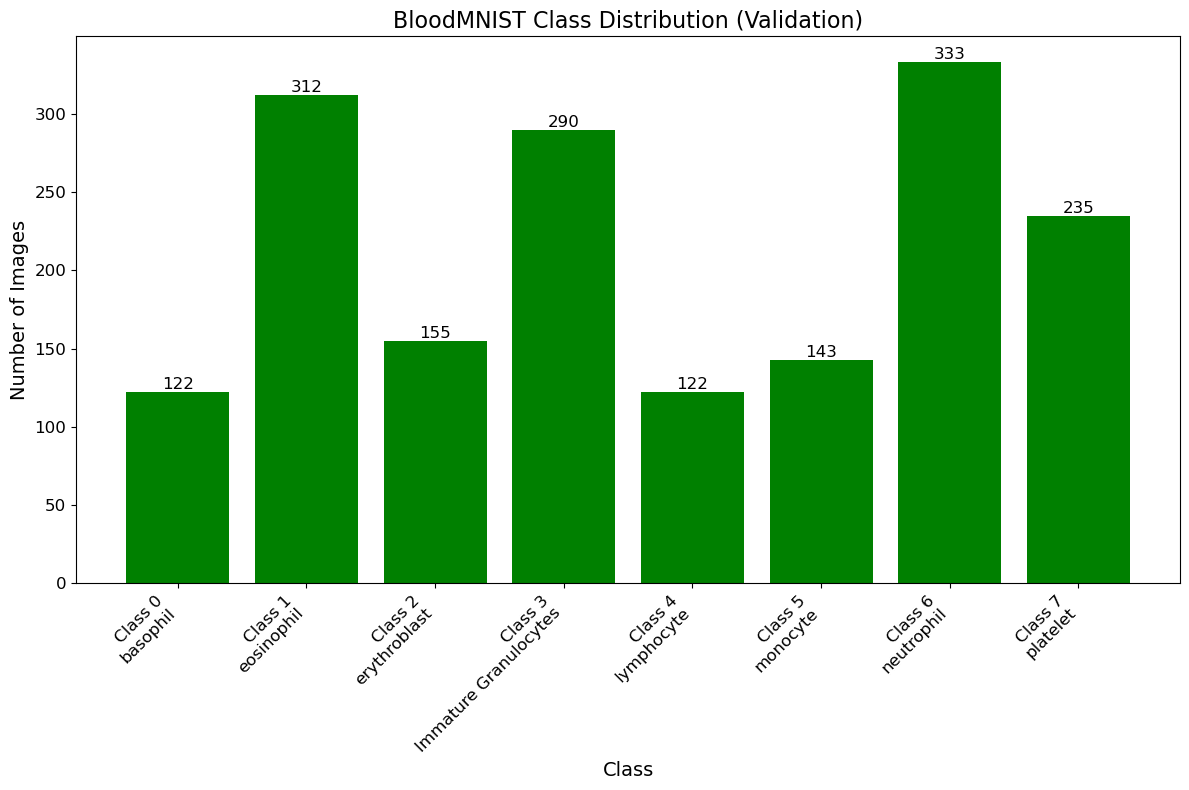

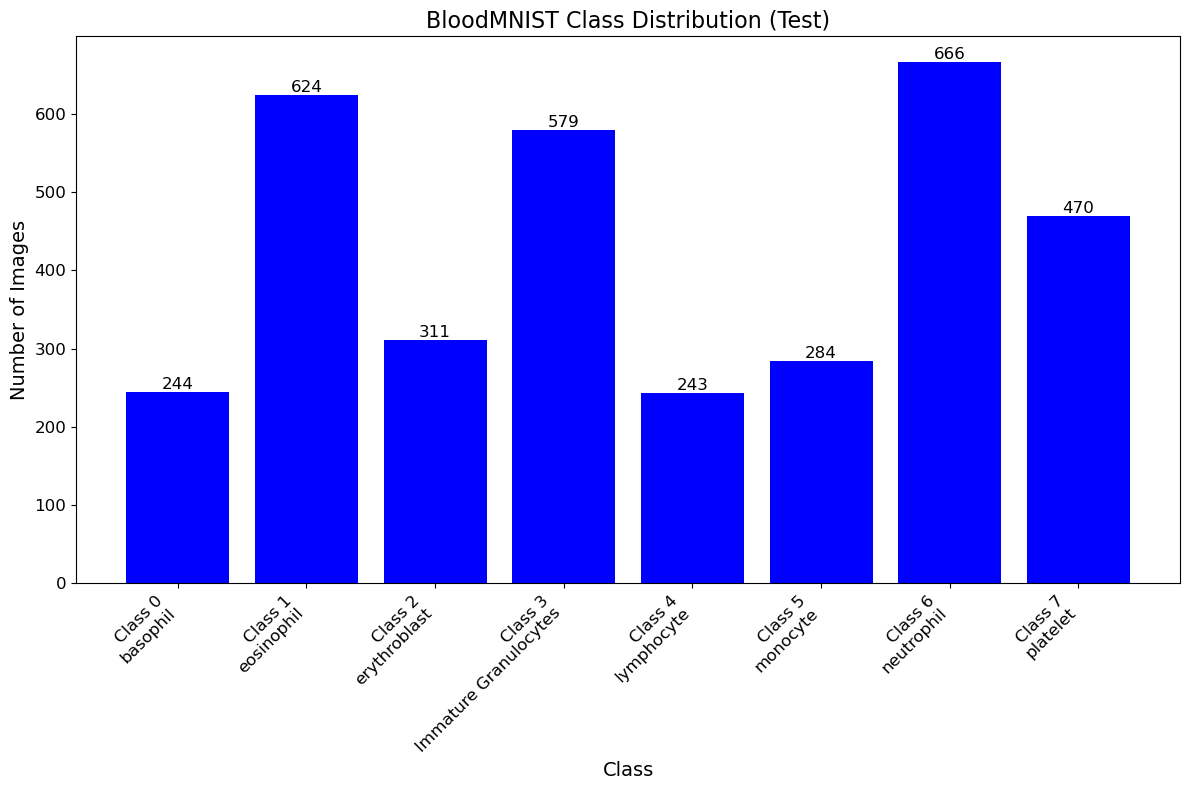

In [7]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Image Preprocessing

- **Binary Thresholding**: Convert images to grayscale and apply a binary threshold to segment the target cells. This step helps in isolating the cells from the background by converting the image to black and white based on a threshold value.

- **Noise Reduction**: Remove small objects from the binary image to focus on the most significant parts of the image (i.e., target cells)

- **Component Labeling**: Label connected components in the binary image and retain the largest connected component, assuming it's the target cell. This step ensures that only the most relevant part of the image is considered.

- **Masking**: Apply the binary mask to the original image to highlight the target cells while suppressing the background and other irrelevant objects.

- **Data Conversion**: Use a class to convert the preprocessed data back to the original data format, which maintains compatibility with PyTorch methods while preserving the data structure for model training and evaluation.


In [8]:
def preprocess_image(image):
    # Convert to grayscale
    gray = rgb2gray(image)
    
    # Apply a binary threshold to segment the target cells
    _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)
    
    # Remove small objects from the binary image
    cleaned = morphology.remove_small_objects(binary > 0, min_size=500)
    
    # Label the connected components
    labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)
    
    # Keep the largest connected component (assuming it's the target cell)
    largest_component = morphology.remove_small_objects(labeled, min_size=500)
    
    # Mask the original image
    masked_image = image * np.dstack([largest_component > 0] * 3)
    
    return masked_image

In [9]:
def show_comparison(dataset, n_images=5):
    """Show comparison of original image to preprocessed image"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
def preprocess_dataset(dataset):
    """Pre-process the entire dataset"""
    preprocessed_data = []
    for img, label in dataset:
        preprocessed_img = preprocess_image(np.array(img))
        preprocessed_data.append((preprocessed_img, label))
    return preprocessed_data

# Preprocess and overwrite the datasets
train_data_preprocessed = preprocess_dataset(train_data)
val_data_preprocessed = preprocess_dataset(val_data)
test_data_preprocessed = preprocess_dataset(test_data)


/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_22609/2280269436.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


In [11]:
# Convert preprocessed data back to original data format
class PreprocessedDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

    def __len__(self):
        return len(self.data)

# Create dataset objects
train_data_preprocessed = PreprocessedDataset(train_data_preprocessed)
val_data_preprocessed = PreprocessedDataset(val_data_preprocessed)
test_data_preprocessed = PreprocessedDataset(test_data_preprocessed)

# Display Images

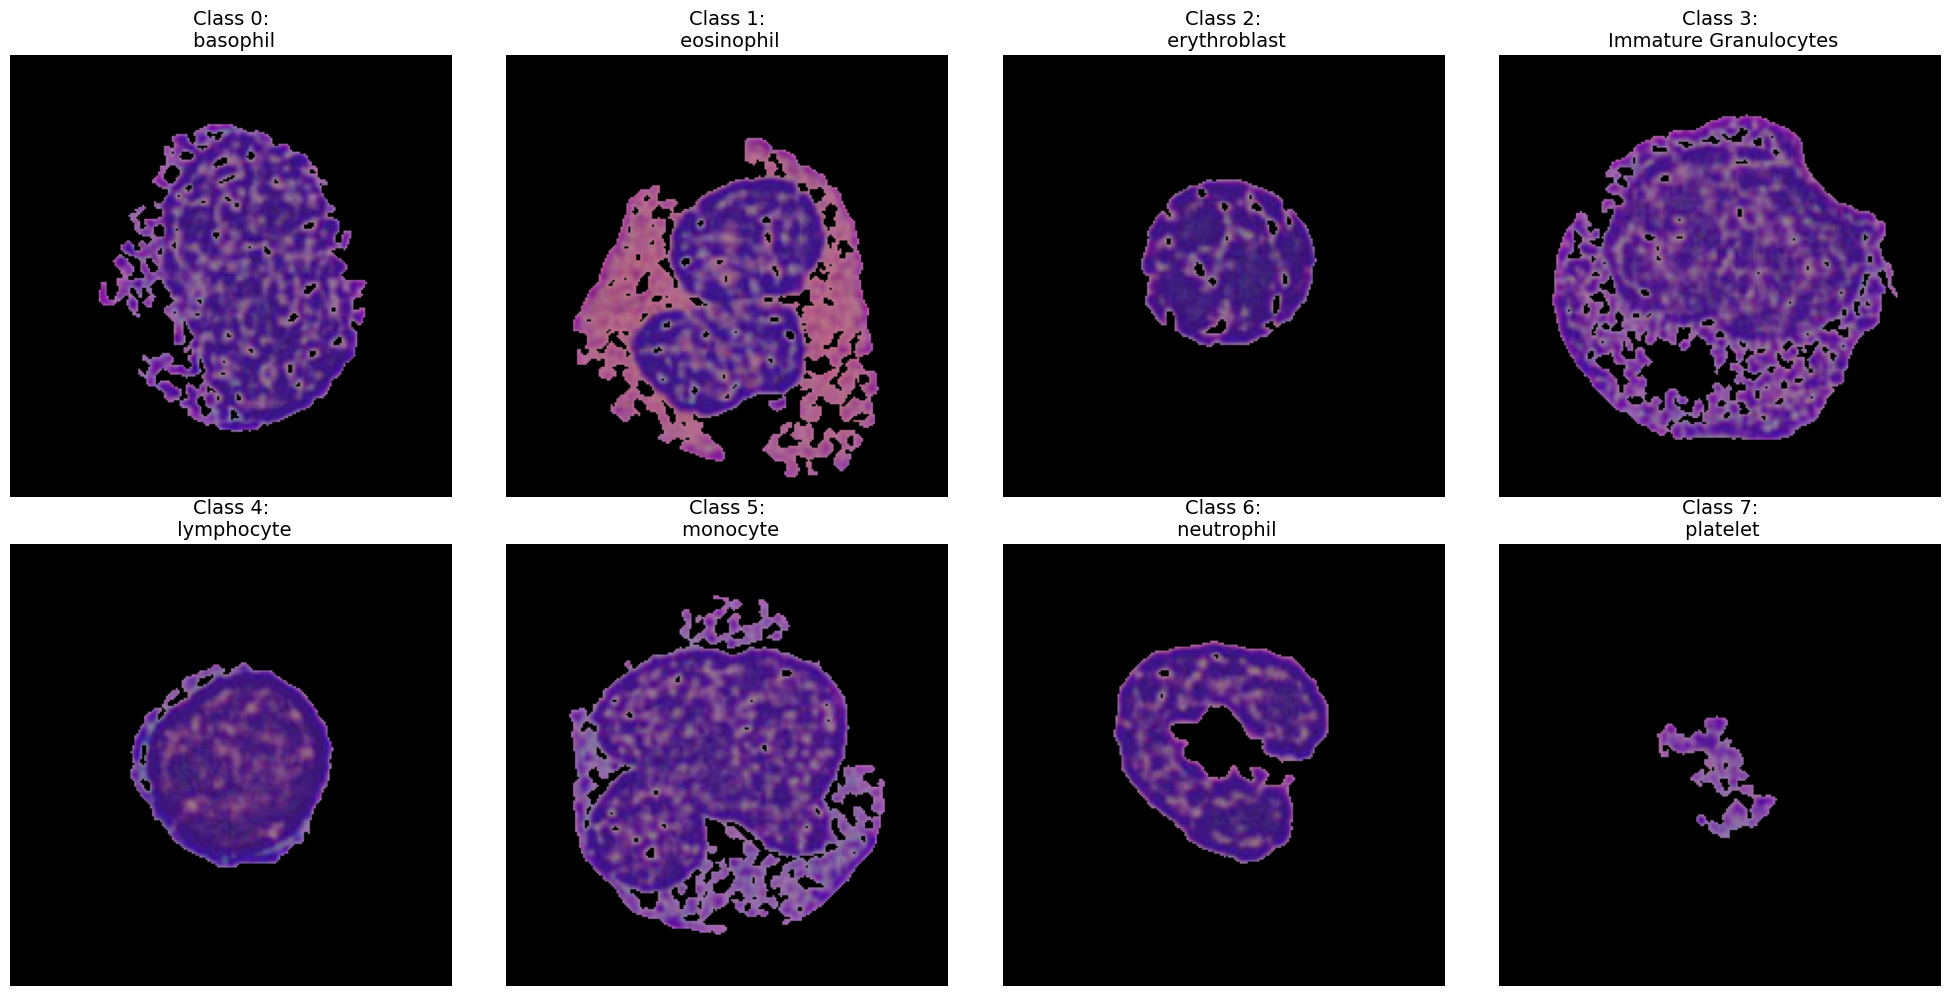

In [12]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    """Randomly show one pre-processed image per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            axes[class_idx].imshow(random_img)
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show one example image from the preprocessed training dataset for each class
show_one_image_per_class(train_data_preprocessed, n_classes_blood, class_labels_blood)

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_22609/2280269436.py:15: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


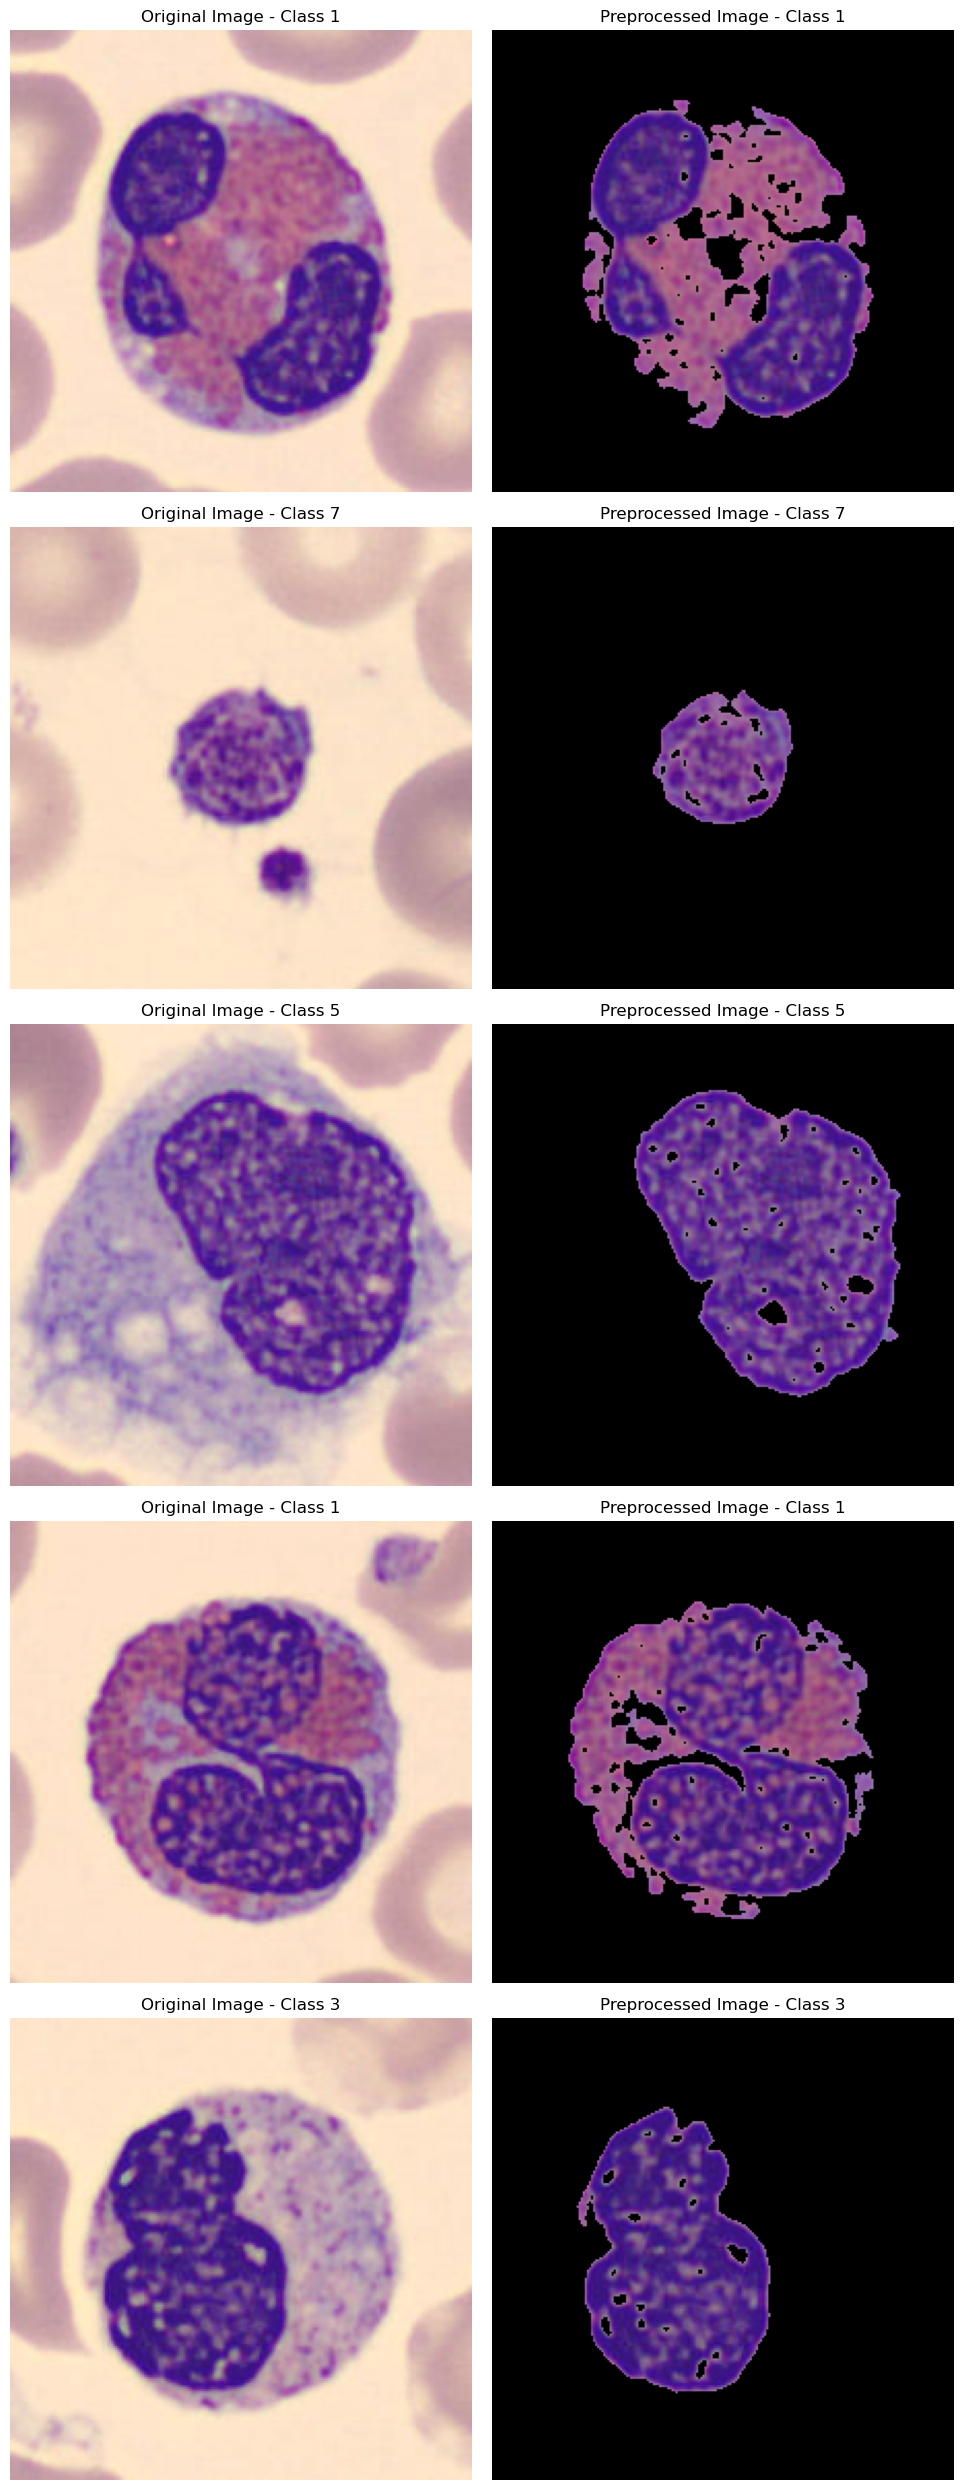

In [13]:
# Show comparison for 5 random images from the training dataset
show_comparison(train_data, n_images=5)